In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from numpy import array
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd     

Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [4]:
LABELS = np.array(['aircraft carrier','airplane','alarm clock','ambulance','angel',
                   'animal migration','ant','anvil','apple','arm','asparagus','axe',
                   'backpack','banana','bandage','barn','baseball','baseball bat',
                   'basket','basketball','bat','bathtub','beach','bear','beard','bed',
                   'bee','belt','bench','bicycle','binoculars','bird','birthday cake',
                   'blackberry','blueberry','book','boomerang','bottlecap','bowtie','bracelet',
                   'brain','bread','bridge','broccoli','broom','bucket','bulldozer','bus','bush',
                   'butterfly','cactus','cake','calculator','calendar','camel','camera','camouflage','campfire','candle','cannon','canoe','car','carrot','castle','cat','ceiling fan','cello','cell phone','chair',
                   'chandelier','church','circle','clarinet','clock','cloud','coffee cup','compass','computer','cookie','cooler','couch','cow','crab','crayon','crocodile','crown','cruise ship','cup','diamond',
                   'dishwasher','diving board','dog','dolphin','donut','door','dragon','dresser','drill','drums','duck','dumbbell','ear','elbow','elephant','envelope','eraser','eye','eyeglasses','face','fan',
                   'feather','fence','finger','fire hydrant','fireplace','firetruck','fish','flamingo','flashlight','flip flops','floor lamp','flower','flying saucer','foot','fork','frog','frying pan','garden',
                   'garden hose','giraffe','goatee','golf club','grapes','grass','guitar','hamburger','hammer','hand','harp','hat','headphones','hedgehog','helicopter','helmet','hexagon','hockey puck','hockey stick',
                   'horse','hospital','hot air balloon','hot dog','hot tub','hourglass','house','house plant','hurricane','ice cream','jacket','jail','kangaroo','key','keyboard','knee','knife','ladder','lantern','laptop',
                   'leaf','leg','light bulb','lighter','lighthouse','lightning','line','lion','lipstick','lobster','lollipop','mailbox','map','marker','matches','megaphone','mermaid','microphone','microwave','monkey',
                   'moon','mosquito','motorbike','mountain','mouse','moustache','mouth','mug','mushroom','nail','necklace','nose','ocean','octagon','octopus','onion','oven','owl','paintbrush','paint can','palm tree',
                   'panda','pants','paper clip','parachute','parrot','passport','peanut','pear','peas','pencil','penguin','piano','pickup truck','picture frame','pig','pillow','pineapple','pizza','pliers','police car',
                   'pond','pool','popsicle','postcard','potato','power outlet','purse','rabbit','raccoon','radio','rain','rainbow','rake','remote control','rhinoceros','rifle','river','roller coaster','rollerskates',
                   'sailboat','sandwich','saw','saxophone','school bus','scissors','scorpion','screwdriver','sea turtle','see saw','shark','sheep','shoe','shorts','shovel','sink','skateboard','skull','skyscraper',
                   'sleeping bag','smiley face','snail','snake','snorkel','snowflake','snowman','soccer ball','sock','speedboat','spider','spoon','spreadsheet','square','squiggle','squirrel','stairs','star','steak',
                   'stereo','stethoscope','stitches','stop sign','stove','strawberry','streetlight','string bean','submarine','suitcase','sun','swan','sweater','swing set','sword','syringe','table','teapot','teddy-bear',
                   'telephone','television','tennis racquet','tent','The Eiffel Tower','The Great Wall of China','The Mona Lisa','tiger','toaster','toe','toilet','tooth','toothbrush','toothpaste','tornado','tractor',
                   'traffic light','train','tree','triangle','trombone','truck','trumpet','t-shirt','umbrella','underwear','van','vase','violin','washing machine','watermelon','waterslide','whale','wheel','windmill',
                   'wine bottle','wine glass','wristwatch','yoga','zebra','zigzag'])

To Download the dataset run the following cell

In [5]:
# for b in LABELS:
#     !wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{b}.npy'

To change the number of images for each class, change the number in variable N in the following cell
To change the number of epochs, change the N_EPOCHS variable below

In [2]:
N_classes = len(LABELS)
classes = {}
files=[]
for i in range(0,N_classes):
  classes.update({i:LABELS[i]})
  files.append(LABELS[i]+".npy")

# number of samples to take in each class
N = 5000

# some other constants
N_EPOCHS = 10
print(N_classes)

In [ ]:
def normalize(data):
    "Takes a list or a list of lists and returns its normalized form"

    return np.interp(data, [0, 255], [0, 1])

In [ ]:
def set_limit(arrays, n):
    "Limit elements from each array up to n elements and return a single list"
    new = []
    for array in arrays:
        i = 0
        for item in array:
            if i == n:
                break
            new.append(item)
            i += 1
    return new


In [ ]:
def make_labels(N1, N2):
    "make labels from 0 to N1, each repeated N2 times"
    labels = []
    for i in range(N1):
        labels += [i] * N2
    return labels

In [7]:
def load(dir, reshaped, files,N):
    "Load .npy or .npz files from disk and return them as numpy arrays.
    Takes in a list of filenames and returns a list of numpy arrays."
    m=0
    data = []
    for file in files:
        f = np.load(dir + file)
        if reshaped:
            new_f = []
            for i in range(N):
                x = np.reshape(f[i], (28, 28))
                x = np.expand_dims(x, axis=0)
                x = np.reshape(f[i], (28, 28, 1))
                new_f.append(x)
            f = new_f
        data.append(f)
        m+=1
        print("loaded file" , m)
    return data

When running for the first time, use the following commented code. Otherwise, read the dump files directly

In [9]:
# data1 = load("", True, files[:170],N)

In [10]:
# with open('outfile2', 'ab') as fp:
#     pickle.dump(data1, fp)

In [8]:
with open('outfile2', 'rb') as fp:
    mynewlist = pickle.load(fp)

In [9]:
len(mynewlist)

170

In [14]:
# data2 = load("", True, files[170:],N)

In [15]:
# with open('outfile1', 'ab') as f:
#     pickle.dump(data2, f)

In [11]:
with open('outfile1', 'rb') as fp:
    mynewlist2 = pickle.load(fp)

In [12]:
len(mynewlist2)

175

In [14]:
data=mynewlist+mynewlist2

In [15]:
len(data)

345

In [16]:
train_data=array(data)

In [17]:
train_data=train_data.reshape(1725000,28,28,1)
print(train_data.shape)

(1725000, 28, 28, 1)


In [18]:
y_trn=[int(i/5000) for i in range(1725000) ]
print(len(y_trn))

Text(0.5, 1.0, '(Label: aircraft carrier)')

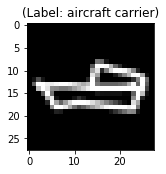

In [52]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
#curr_lbl = y_trn[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(LABELS[int(10/5000)]) + ")")


In [ ]:
train_data = train_data / np.max(train_data)

In [31]:
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [21]:
batch_size = 64
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 345

In [24]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [25]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Instructions for updating:
Colocations handled automatically by placer.


In [35]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [36]:
callback = [EarlyStopping(patience=1),
                ReduceLROnPlateau(patience=5, verbose=1),
                CSVLogger('autoencoder1log.csv'),
                ModelCheckpoint('autoencoder1.check',
                                save_best_only=True,
                                save_weights_only=True)]


In [39]:
autoencoder_train = autoencoder.fit(train_X, train_ground, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,validation_data=(valid_X, valid_ground),
                                   callbacks=callback)

Instructions for updating:
Use tf.cast instead.
Train on 1380000 samples, validate on 345000 samples
Epoch 1/10
1380000/1380000 [==============================] - 418s 303us/step - loss: 0.0038 - val_loss: 0.0013
Epoch 2/10
1380000/1380000 [==============================] - 410s 297us/step - loss: 0.0011 - val_loss: 9.6705e-04
Epoch 3/10
1380000/1380000 [==============================] - 410s 297us/step - loss: 7.6322e-04 - val_loss: 6.6480e-04
Epoch 4/10
1380000/1380000 [==============================] - 411s 297us/step - loss: 6.2850e-04 - val_loss: 5.8311e-04
Epoch 5/10
1380000/1380000 [==============================] - 409s 296us/step - loss: 5.4927e-04 - val_loss: 5.7942e-04
Epoch 6/10
1380000/1380000 [==============================] - 410s 297us/step - loss: 4.9535e-04 - val_loss: 4.6772e-04
Epoch 7/10
1380000/1380000 [==============================] - 415s 301us/step - loss: 3.8263e-04 - val_loss: 3.5761e-04


In [52]:
print(autoencoder_train.history['loss'])
with open('1stenoder_decoder_history', 'ab') as f:
    pickle.dump(autoencoder_train.history, f)

[0.0038354183141061145, 0.0010514283568503848, 0.0007632209885959932, 0.0006284985408159917, 0.0005492711198421708, 0.000495349409694419, 0.0004561804386071753, 0.00042646799602181367, 0.000402564999198649, 0.00038263348515577396]


In [52]:
hist1={}
with open('1stenoder_decoder_history', 'rb') as fp:
    hist1=pickle.load(fp)
print(hist1)

{'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 'val_loss': [0.001308246897228494, 0.0009670524367765672, 0.0006648031406644462, 0.000583110145703498, 0.0005794174591740728, 0.00046772417339590797, 0.00042701520173661953, 0.00039817965033774576, 0.000356098240725966, 0.00035760951291067877], 'loss': [0.0038354183141061145, 0.0010514283568503848, 0.0007632209885959932, 0.0006284985408159917, 0.0005492711198421708, 0.000495349409694419, 0.0004561804386071753, 0.00042646799602181367, 0.000402564999198649, 0.00038263348515577396]}


In [57]:
autoencoder.save_weights('autoencoder.h5')

In [26]:
autoencoder.load_weights('autoencoder.h5')

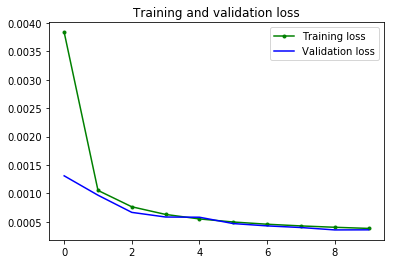

In [54]:
loss = hist1['loss']
val_loss = hist1['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, color='green',marker='o',markersize=3, label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [27]:
train_labels=[int(i/5000) for i in range(0,1725000) ]
print(len(train_labels))
train_Y_one_hot = to_categorical(train_labels)


# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

1725000
Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [28]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

In [29]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((1380000, 28, 28, 1), (345000, 28, 28, 1), (1380000, 345), (345000, 345))

In [30]:
 def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [31]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [32]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [33]:
autoencoder.load_weights('autoencoder.h5')

In [34]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [34]:
autoencoder.get_weights()[0][1]

array([[[-4.96307500e-02, -2.64959073e+00, -2.95178536e-02,
         -1.04676616e+00,  8.68936330e-02,  9.69107687e-01,
         -3.41910064e-01, -1.04533744e+00,  2.15702150e-02,
          9.40196663e-02, -1.34976879e-01,  2.96876907e-01,
          5.84321916e-01, -5.39822757e-01, -4.51260544e-02,
          5.94212353e-01, -1.09639955e+00,  5.36705196e-01,
          1.41507089e-02, -1.67508766e-01,  7.95525908e-01,
          3.53343487e-01, -9.92079079e-02, -8.06467533e-02,
         -1.32826716e-02,  2.07283989e-01, -5.90708060e-03,
          1.21571738e-02,  6.92274034e-01,  2.36996189e-01,
          3.68026793e-01,  1.28752083e-01]],

       [[-9.99432206e-01, -3.61994833e-01,  6.22246452e-02,
         -3.17913115e-01, -1.73977047e-01,  1.88833103e-01,
          2.58020163e-01, -3.44199419e-01, -9.90749747e-02,
          2.56630957e-01,  6.25503361e-01,  5.67679882e-01,
         -7.68977642e-01, -1.34592497e+00,  3.72137517e-01,
          1.64162561e-01,  6.66346550e-02, -7.01439083

In [35]:
full_model.get_weights()[0][1]

array([[[-4.96307500e-02, -2.64959073e+00, -2.95178536e-02,
         -1.04676616e+00,  8.68936330e-02,  9.69107687e-01,
         -3.41910064e-01, -1.04533744e+00,  2.15702150e-02,
          9.40196663e-02, -1.34976879e-01,  2.96876907e-01,
          5.84321916e-01, -5.39822757e-01, -4.51260544e-02,
          5.94212353e-01, -1.09639955e+00,  5.36705196e-01,
          1.41507089e-02, -1.67508766e-01,  7.95525908e-01,
          3.53343487e-01, -9.92079079e-02, -8.06467533e-02,
         -1.32826716e-02,  2.07283989e-01, -5.90708060e-03,
          1.21571738e-02,  6.92274034e-01,  2.36996189e-01,
          3.68026793e-01,  1.28752083e-01]],

       [[-9.99432206e-01, -3.61994833e-01,  6.22246452e-02,
         -3.17913115e-01, -1.73977047e-01,  1.88833103e-01,
          2.58020163e-01, -3.44199419e-01, -9.90749747e-02,
          2.56630957e-01,  6.25503361e-01,  5.67679882e-01,
         -7.68977642e-01, -1.34592497e+00,  3.72137517e-01,
          1.64162561e-01,  6.66346550e-02, -7.01439083

Training the encoder only by freezing all the layers except for the softmax. (Equivalent to forward prop)

In [35]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [36]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [37]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [48]:
callback = [EarlyStopping(patience=1),
                ReduceLROnPlateau(patience=5, verbose=1),
                CSVLogger('autoencoder2log.csv'),
                ModelCheckpoint('autoencoder2.check',
                                save_best_only=True,
                                save_weights_only=True)]


In [49]:
classify_train1 = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label),
                               callbacks=callback)

Train on 1380000 samples, validate on 345000 samples
Epoch 1/10
1380000/1380000 [==============================] - 311s 225us/step - loss: 0.9908 - acc: 0.7456 - val_loss: 1.4193 - val_acc: 0.6697
Epoch 2/10
1380000/1380000 [==============================] - 310s 225us/step - loss: 0.9594 - acc: 0.7520 - val_loss: 1.4314 - val_acc: 0.6683


In [45]:
print(classify_train1.history['loss'])
with open('2ndenoder_frozen_layers_history', 'ab') as f:
    pickle.dump(classify_train1.history, f)

[4.243615139256353, 2.5253372522437054, 1.5982954666801121, 1.3917932612515878, 1.2857363125925478, 1.2132655101859051, 1.1558103859376216, 1.1065416088145712, 1.0638978254221487, 1.0250822344130364]


In [55]:
hist2={}
with open('2ndenoder_frozen_layers_history', 'rb') as fp:
    hist2=pickle.load(fp)
print(hist2)

{'acc': [0.09238260869565218, 0.42823623188405796, 0.6184746376811594, 0.6615913043478261, 0.6841956521739131, 0.6990231884057971, 0.7112413043478261, 0.7214971014492754, 0.7302231884057971, 0.7382927536231884], 'val_acc': [0.21906376811663308, 0.5729014492746712, 0.627350724636299, 0.6565652173899222, 0.6635884057943372, 0.6705710144899893, 0.6708869565217391, 0.6677420289841252, 0.6676695652160092, 0.6705478260883386], 'val_loss': [3.530719070390342, 1.8329122219832048, 1.5526416277152904, 1.426248057199561, 1.39469667360057, 1.3780955582521963, 1.3865797946487648, 1.392540967443715, 1.41546358158001, 1.4057581524337548], 'loss': [4.243615139256353, 2.5253372522437054, 1.5982954666801121, 1.3917932612515878, 1.2857363125925478, 1.2132655101859051, 1.1558103859376216, 1.1065416088145712, 1.0638978254221487, 1.0250822344130364], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


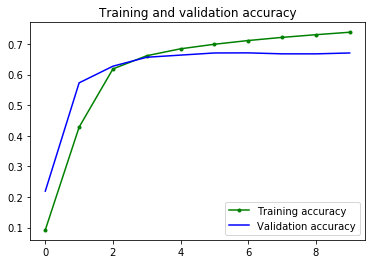

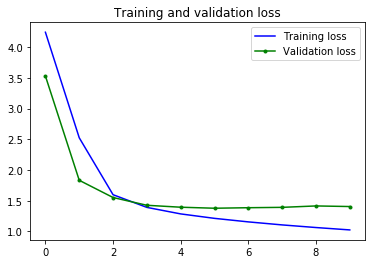

In [57]:
accuracy = hist2['acc']
val_accuracy = hist2['val_acc']
loss = hist2['loss']
val_loss = hist2['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy,color='green',marker='o',markersize=3, label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, color='green',marker='o',markersize=3, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [40]:
full_model.save_weights('autoencoder_classification.h5')

Now training the encoder by unfreezing all the layers

In [41]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [42]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [43]:
callback = [EarlyStopping(patience=5),
                ReduceLROnPlateau(patience=5, verbose=1),
                CSVLogger('autoencoder3log.csv'),
                ModelCheckpoint('autoencoder3.check',
                                save_best_only=True,
                                save_weights_only=True)]


In [64]:
classify_train2 = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label),
                                callbacks=callback)

Train on 1380000 samples, validate on 345000 samples
Epoch 1/10
1380000/1380000 [==============================] - 309s 224us/step - loss: 0.8547 - acc: 0.7739 - val_loss: 1.5302 - val_acc: 0.6598
Epoch 2/10
1380000/1380000 [==============================] - 309s 224us/step - loss: 0.8315 - acc: 0.7785 - val_loss: 1.6022 - val_acc: 0.6579
Epoch 3/10
1380000/1380000 [==============================] - 310s 224us/step - loss: 0.8115 - acc: 0.7827 - val_loss: 1.6235 - val_acc: 0.6583
Epoch 4/10
1380000/1380000 [==============================] - 308s 223us/step - loss: 0.7921 - acc: 0.7874 - val_loss: 1.6921 - val_acc: 0.6548
Epoch 5/10
1380000/1380000 [==============================] - 310s 224us/step - loss: 0.7732 - acc: 0.7908 - val_loss: 1.6794 - val_acc: 0.6488
Epoch 6/10
1380000/1380000 [==============================] - 309s 224us/step - loss: 0.7579 - acc: 0.7941 - val_loss: 1.6542 - val_acc: 0.6492
Epoch 7/10
1380000/1380000 [==============================] - 311s 226us/step - los

In [3]:
with open('3rdenoder_trainable_layers_history', 'ab') as f:
    pickle.dump(classify_train2.history, f)

In [83]:
hist3={}
with open('3rdenoder_trainable_layers_history', 'rb') as fp:
    hist3=pickle.load(fp)
print(hist3)

{'acc': [0.758036231884058, 0.7637036231884058, 0.7692449275362319], 'val_acc': [0.6631913043478261, 0.6627565217391305, 0.6590492753623188], 'val_loss': [1.5134372870929, 1.5043945144017536, 1.5474336289696071], 'loss': [0.9295717352203701, 0.9021531328850898, 0.8772413428652114], 'lr': [0.001, 0.001, 0.001]}


In [67]:
full_model.save_weights('classification_complete.h5')

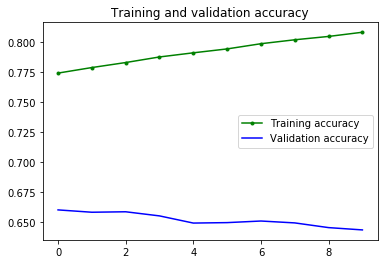

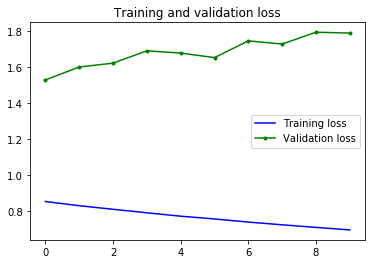

In [84]:
accuracy = classify_train2.history['acc']
val_accuracy = classify_train2.history['val_acc']
loss = classify_train2.history['loss']
val_loss = classify_train2.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, color='green',marker='o',markersize=3, label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, color='green',marker='o',markersize=3, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Testing on random 10 images of each classes

In [70]:
with open('test_final', 'rb') as ft:
    testlist = pickle.load(ft)

In [75]:
testlist = list(map(normalize, testlist))

In [77]:
test_labels = make_labels(345, 10)
test_Y = keras.utils.to_categorical(test_labels, 345)

In [78]:
testlist = set_limit(testlist, 5000)

In [79]:
len(testlist)

3450

In [81]:
predsTest = full_model.predict(np.array(testlist))
# print(predsTest)
score = 0
for i in range(len(predsTest)):
    #print(np.argmax(predsTest[i]))
    if np.argmax(predsTest[i]) == test_labels[i]:
        score += 1

print("Accuracy: ", ((score + 0.0) / len(predsTest)) * 100,"%")

Accuracy:  64.6086956521739 %
